# Genetic Algorithms

This notebook covers in depth how genetic algorithms (GA) works. This notebook provides examples, theorems, proofs, solutions and code.

## Explanation

### Introduction

In computer science and operations research, a genetic algorithm (GA) is a metaheuristic inspired by the process of natural selection and belongs to the broader class of evolutionary algorithms. Genetic algorithms are commonly used to generate high-quality solutions to optimization and search problems through biologically inspired operators such as selection, crossover, and mutation. They can be highly efficient and easy to implement. Moreover, only a few modifications are needed to adapt a GA for different problems.

Therefore, GAs are often used in machine learning to determine the best hyper-parameters of a model.

In [11]:
# Some usefull packages we will use
import matplotlib.pyplot as plt # To plot results
import random as rd # You can use numpy.random if you prefer
import math # You can use numpy's function if you prefer
import time
from IPython import display # To clear output (then we will have "animations")

### Objective fonction

GAs are designed for optimization problems, i.e., problems of the form:

Let $\mathcal{C}$ be the set of feasible solutions (the set of solutions that satisfy the contraints of the problem).

Let $f: \mathcal{C} \rightarrow \mathbb{R}$ the function we want to maximize (or minimize, depending on the case. Note that maximizing $f$ is equivalent to minimizing $−f$).

Then, our goal is to find:
$$\underset{x\in\mathcal{C}}{argmax} \{f(x)\}$$

For the following explanations, we will attempt to find the maximum value of a simple function:
$$f: \begin{cases}
      [-5,3] \rightarrow \mathbb{R}\\
      x \mapsto -x^4 -3x^3 +10x^2 +6x -4
    \end{cases}$$

In [12]:
f = lambda x: -x**4 -3*x**3 +10*x**2 +6*x -4
f_min = -5
f_max = 3

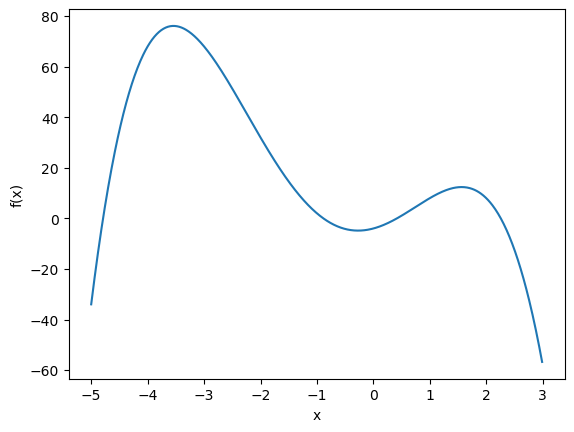

In [13]:
def plot_f(show=True, f_min=f_min, f_max=f_max, ratio=100):
    ratio = int(ratio)
    x = [x/ratio for x in range(int(f_min*ratio), int(f_max*ratio))]
    y = [f(x) for x in x]
    plt.plot(x, y, "-")
    plt.xlabel("x")
    plt.ylabel("f(x)")
    if show:
        plt.show()
plot_f(show=True)

The **objective function** in a GA problem is the function we aim to optimize (i.e., to find its minimum or maximum). In this case, the objective function is $f$.

### Score

The **score** of a solution $x\in \mathcal{C}$ is the value $f(x)$ of the objective function at this point. If you want to find the minimum of $f$, simply find the maximum of $-f$.

We says that a solution $x$ is **better** than a solution $y$ (denoted as $x \preceq y$) if and only if $f(x) \geq f(y)$. A solution $x$ is **strickly better** than a solution $y$ (denoted as $x \prec y$) if and only if $f(x) > f(y)$.

The **best solutions** is the solutions of the set $\underset{x\in\mathcal{C}}{argmax} \{f(x)\}$.

Therefore, our goal is to find one of the best solutions because a function can have multiple global maximum.

In [14]:
def S(x):
    """Return the score of x"""
    return f(x)  # to find the maximum of f
    # return -f(x) # to find the minimum of f

### Generation

#### Population

A **population** $P$ is a set of feasible solutions. $\forall k \leq  |P|$, we denote by $P[k]$ the $k$-th better solution of $P$. Then, $\forall i,j$, if $i\leq j$ then $P[i] \preceq P[j]$. It is equivalent to said that $P$ is a sorteed sequences with the function $x \mapsto -\mathcal{S}(x)$.

GAs follow the natural selection process. They take a population $P_n$ and attempt to construct an new population $P_{n+1}$ based on the best solutions from $P_n$. We construct the population $P_{n+1}$ by:
 - Keeping a proportion $\varepsilon_0$ of the best solutions from $P_n$,
 - Adding $\varepsilon_1$ cross-overs,
 - Adding $\varepsilon_2$ mutations,
 - Adding $\varepsilon_3$ random new solutions.

Here, $\varepsilon_0,\varepsilon_1,\varepsilon_2,\varepsilon_3$ are constants in $[0,1]$. The process of moving from $P_n$ to $P_{n+1}$ is called a **generation**. We repeat this process a fixed number of times, denoted as $M \in \mathbb{N}$.

A genetic algorithm follows these steps:
 - Construct an initial random population $P_0$
 - for i going from 1 to $M$:
    - Construct $P_{i}$ from $P_{i-1}$
 - Return $P_M$

For the implementation part, we ensure that all population have a fixed size `LEN_POP` $\in \mathbb{N}$. Otherwise, populations could grow uncontrollably, leading to exponential computational times. Therefore $\varepsilon_0 + \varepsilon_1 + \varepsilon_2 + \varepsilon_3 = 1$ such that $\forall i \in \{0,...,M-1\}, |P_{i+1}| = (\varepsilon_0 + \varepsilon_1 + \varepsilon_2 + \varepsilon_3)|P_i| = |P_i|$.

In [15]:
LEN_POP = 100
NB_GEN = 15 # It is the number M

#### Cenerate solution

As mentioned earlier, we want to generate random solutions and random populations for our problem. However, since the score function can take a long time to compute, we want to calculate the score of a solution only once. Therefore, we will create a Python class called `Solution` to store both the solution and its score.

In [16]:
class Solution():
    def __init__(self, sol, score):
        self.sol = sol
        self.score = score

In [17]:
def gen_sol():
    x = rd.uniform(f_min, f_max) # Generate random real number between f_min and f_max uniformally
    return Solution(x, S(x))

def gen_pop():
    return [gen_sol() for _ in range(LEN_POP)]

Notice that the function `gen_pop()` stays the same no matter the problem.

Let's visualise a random population.

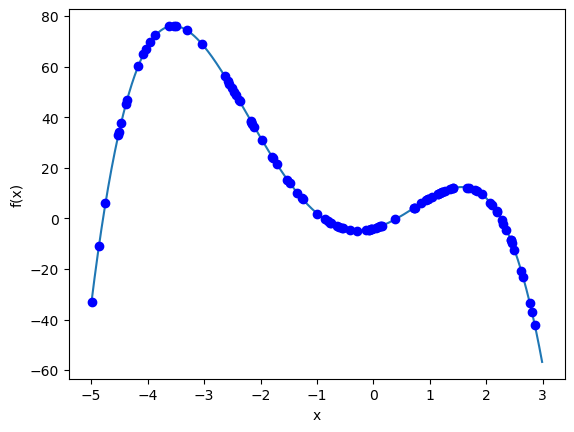

In [18]:
plot_f(show=False)
pop = gen_pop()

def plot_pop(pop, color, legend=""):
    solutions = [sol.sol for sol in pop]
    solutions_score = [S(sol) for sol in solutions]
    plt.plot(solutions, solutions_score, 'o', color=color, label=legend)

plot_pop(pop, "blue")
plt.show()

#### Cross-over

Genetic algorithms are based on two main heuristic: cross-over and mutation.

A **cross-over** of two solutions $x$ and $y$ is an other solution $\phi(x,y)$ such that $\phi(x,y)$ try to fit as best as possible the similarities of $x$ and $y$. A cross-over is the equivalent of natural reproduction. The cross-over of $x$ and $y$ is often called the **child** of $x$ and $y$.

For example:
 - if $\mathcal{C} = \mathbb{R}$, a good cross-over function is $\phi : (x,y) \mapsto \frac{x+y}{2}$
 - if $\mathcal{C} = \mathbb{R}^n$, a good cross-over function is $\phi : ((x_i)_{1\leq i\leq n},(y_i)_{1\leq i\leq n}) \mapsto (\frac{x_i+y_i}{2})_{1\leq i\leq n}$

You will see other example where the solution are some list, graphs or new class in tutorials.

In [19]:
def cross_over(x:Solution, y:Solution):
    z = (x.sol + y.sol)/2
    return Solution(z, S(z))

Let's visualize what some cross_over.

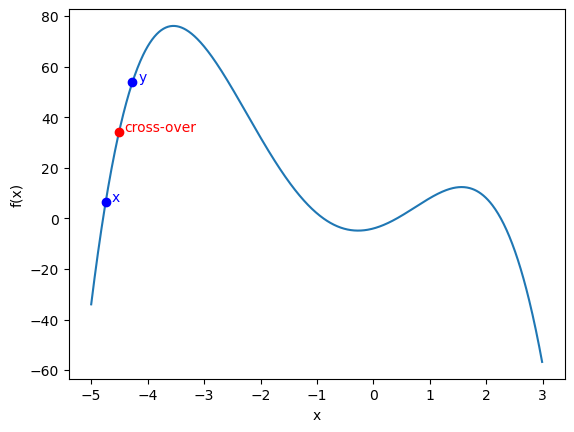

In [20]:
x = gen_sol()
y = gen_sol()
z = cross_over(x, y)

def plot_sol(x, color="blue", msg=""):
    plt.plot(x.sol, x.score, 'o', color=color)
    plt.text(x.sol+0.1, x.score+0.3, msg, color=color)

plot_f(show=False)
plot_sol(x, msg="x")
plot_sol(y, msg="y")
plot_sol(z, color="red", msg="cross-over")
plt.show()

#### Mutations

As you may know, in genetics, some mutations randomly occur, creating new solutions that can be either better or worse.

A **mutation** of a solution $x$ is a slight modification of $x$, denoted $\psi(x)$.

For example:
 - if $\mathcal{C} = \mathbb{R}$, a good mutation function is $\psi : x \mapsto x + \delta$, for some small $\delta \in \mathbb{R}$.
 - if $\mathcal{C} = \mathbb{R}^n$, a good mutation function is $\phi : (x_i)_{1\leq i\leq n} \mapsto (x_i+p\delta)_{1\leq i\leq n}$, where $\delta \in \mathbb{R}$ is a small value, and $p = 1$ with a fixed probability and $0$ otherwise.

You will see other examples in tutorials where solutions can be lists, graphs, or custom classes.

In [21]:
def mutate(x: Solution):
    delta = rd.random()/2
    y = x.sol + delta * (-1) ** rd.randint(0,1)
    return Solution(y, S(y))

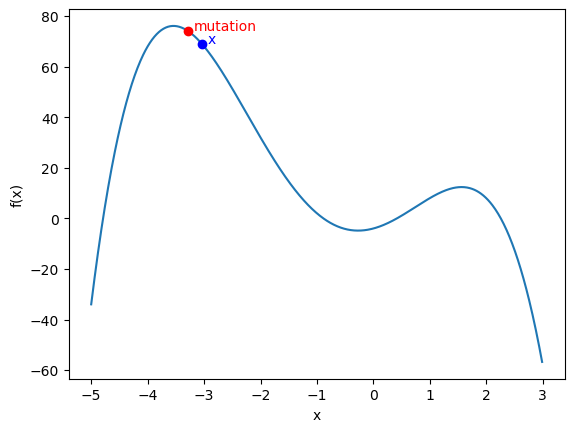

In [22]:
x = gen_sol()
y = mutate(x)

plot_f(show=False)
plot_sol(x, msg="x")
plot_sol(y, color="red", msg="mutation")
plt.show()

### Creating $P_{n+1}$

#### Sorting population

As said previously, we want that $\forall i,j$, $i\leq j \Rightarrow pop[i]\preceq pop[j] \Rightarrow S(pop[i]) \geq S(pop[j])$. Then we want to sort the population `pop`.

In [23]:
def sort_pop(pop):
    pop.sort(key=lambda x:-x.score)

sort_pop(pop)

#### Constants

First we define all the constants $\varepsilon_0, \varepsilon_1, \varepsilon_2$, known as hyperparameters (i.e. parameters defined by the user). If you are working on a reinforcement learning project, you will need to experiment with these hyperparameters to find the best solution in the shortest time possible.  Then $\varepsilon_3 = 1-\varepsilon_0 - \varepsilon_1 -  \varepsilon_2$.

Depending on the problem, you may want to adjust the number of mutations or crossovers accordingly.

In [24]:
epsilon_0 = 0.3
epsilon_1 = 0.3
epsilon_2 = 0.2
epsilon_3 = 1 - epsilon_0 - epsilon_1 - epsilon_2

print(epsilon_0, epsilon_1, epsilon_2, epsilon_3)
# Note that they might be aproximation error due to the float representation in machine

0.3 0.3 0.2 0.19999999999999996


#### Kept solutions

First, we will keep the $\varepsilon_0$ best solutions of the population `pop`.

In [25]:
def np_keep(pop):
    new_pop = []
    for i in range(int(epsilon_0 * LEN_POP)):
        new_pop.append(pop[i])
    return new_pop

[]

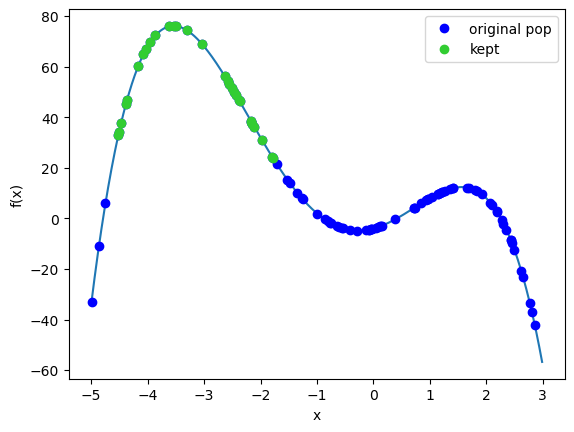

In [26]:
kept = np_keep(pop)
plot_f(False)
plot_pop(pop, "blue", "original pop")
plot_pop(kept, "limegreen", "kept")
plt.legend(loc="upper right")
plt.plot()

#### Cross-Over

Note that its seems better to make cross-over from two good solutions of $P_n$ than with two random solutions of $P_n$. Of course, this is a heuristique.

Then we want a $K\in \mathbb{N}$ such that
$$|\{\phi(P_n[i], P_n[j]),\; i\in\{1,...,K\}, j \in \{i+1,...,K\}\}| = \varepsilon_1N$$

Therefore,
$$K = \lfloor \frac{1 + \sqrt{1+8\varepsilon_1N}}{2} \rfloor$$

In [27]:
def np_cross_over(pop):
    new_pop = []
    K = int( (1 + math.sqrt(1 + 8*epsilon_1*LEN_POP)) / 2 )
    for i in range(K):
        for j in range(i+1, K):
            new_pop.append(cross_over(pop[i], pop[j]))
    return new_pop

[]

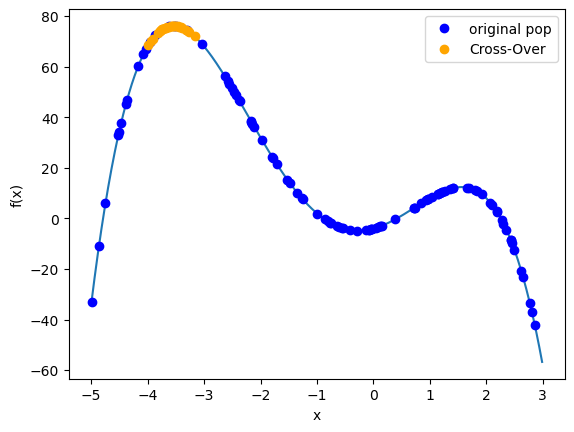

In [28]:
cross_overs = np_cross_over(pop)
plot_f(False)
plot_pop(pop, "blue", "original pop")
plot_pop(cross_overs, "orange", "Cross-Over")
plt.legend(loc="upper right")
plt.plot()

#### Mutations

Similarily, its seems better to make mutations from the best solutions.

Then we want to add :
$$\{\psi(P_n[i]),\; i\in\{1,...,\lfloor \varepsilon_2 M\rfloor\}\}$$

In [29]:
def np_mutation(pop):
    new_pop = []
    for i in range(int(LEN_POP*epsilon_2)):
        new_pop.append(mutate(pop[i]))
    return new_pop

[]

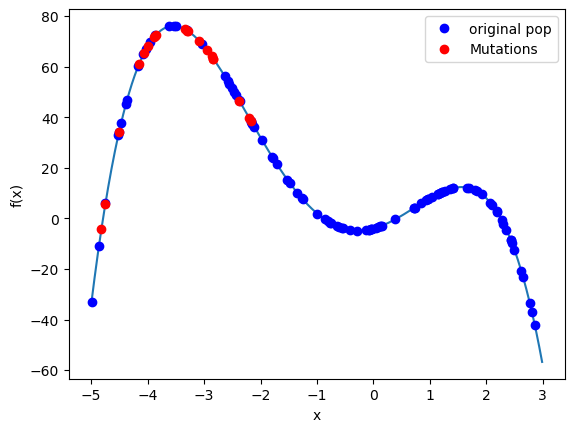

In [30]:
mutations = np_mutation(pop)
plot_f(False)
plot_pop(pop, "blue", "original pop")
plot_pop(mutations, "red", "Mutations")
plt.legend(loc="upper right")
plt.plot()

#### New solutions

Then, we add the $\varepsilon_3$ new random solutions.

In [31]:
def np_new_solutions(pop):
    new_pop = []
    for _ in range(int(epsilon_3 * LEN_POP)):
        new_pop.append(gen_sol())
    return new_pop

[]

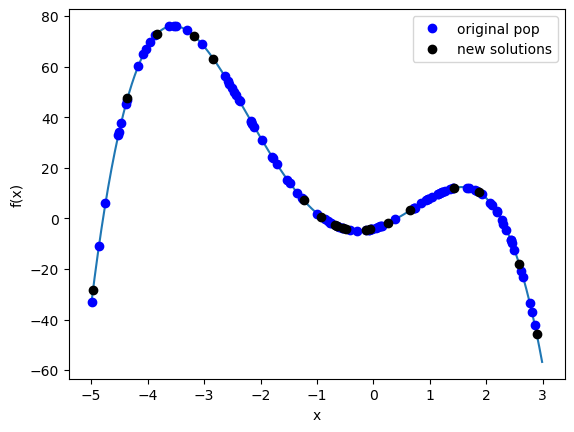

In [32]:
news = np_new_solutions(pop)
plot_f(False)
plot_pop(pop, "blue", "original pop")
plot_pop(news, "black", "new solutions")
plt.legend(loc="upper right")
plt.plot()

#### Complete function

In [33]:
def create_next_pop(pop, show=False):
    # pop is supposed to be sorted
    kept = np_keep(pop)
    cross_overs = np_cross_over(pop)
    mutations = np_mutation(pop)
    news = np_new_solutions(pop)
    
    if show: 
        plot_f(False)
        plot_pop(pop, "blue", "original pop")
        plot_pop(kept, "limegreen", "kept")
        plot_pop(cross_overs, "orange", "cross-over")
        plot_pop(mutations, "red", "mutation")
        plot_pop(news, "black", "new solutions")
        plt.legend(loc="upper right")
        plt.plot()
    new_pop = kept + cross_overs + mutations + news
    return new_pop

97


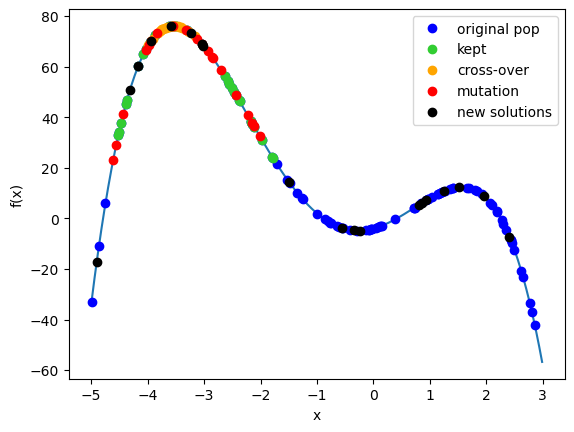

In [34]:
next_pop = create_next_pop(pop, True)
print(len(next_pop))

### Algorithm

Finally, we just have to compute the next generation `NB_GEN` times.

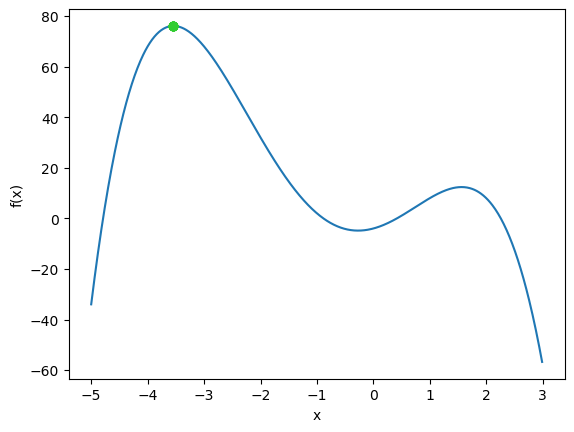

14 

In [35]:
def aglo_gen(show=False):
    pop = gen_pop()
    best_at_gen = []
    for gen in range(NB_GEN):
        sort_pop(pop)
        best_at_gen.append(pop[0])
        pop = create_next_pop(pop)

        if show:
            plot_f(show=False)
            pop_to_print = pop[:10]
            plot_pop(pop_to_print, "limegreen")
            display.clear_output(wait=True)
            plt.show()
            time.sleep(0.1)
            print(gen, end=" ")
    return pop[0], best_at_gen #The best solution the algo found

best, best_at_each_gen = aglo_gen(show=True)

Here, we are ploting the score of the best solution we found at each generation.

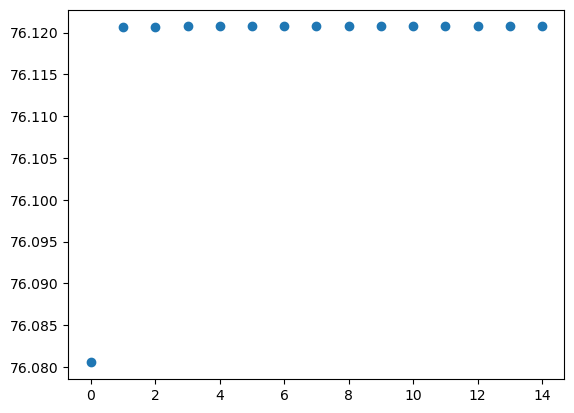

In [36]:
x_liste = [i for i in range(NB_GEN)]
y_liste = [sol.score for sol in best_at_each_gen]
plt.plot(x_liste, y_liste, "o")
plt.show()

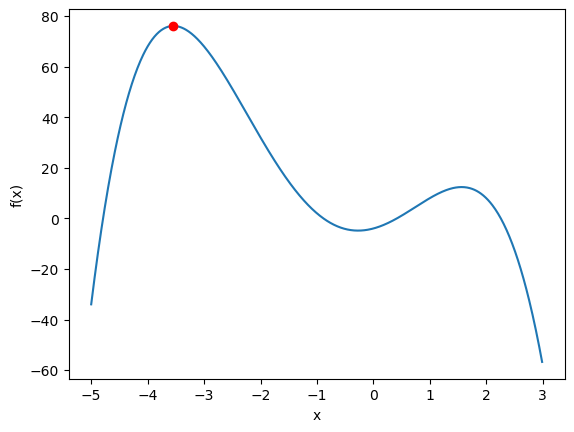

In [37]:
plot_f(False)
plt.plot(best.sol, best.score, "o", color="red")

Then a genetic algorithm can be simply represented with the next figure.

<img src="images/GeneticAlgoPrinciple.png" alt="drawing" width="600"/>

## Proof of genetic algorithm

The goal of this part is to show that genetic algorithm converge, i.e. to prove that genetic algorithm wroks. This part is only theoritical.

### Definitions

Let $x\in \mathcal{C}$ be a solution. The **neighborhood of $x$**, denoted by $\mathcal{N}(x)$ defined as the set of all possible mutations and cross-overs involving $x$.

Let $x,y \in\mathcal{C}$ be two solutions. We says that **$x$ can reach $y$** if there exist an integer $k\in\mathbb{N}$ and a sequence of $k$ solutions $x_1,...,x_k$ such that $x_1 = x$, $x_k=y$ and $\forall i \in \{1,...,k-1\}$, $x_{i+1} \in \mathcal{N}(x_i)$.

### Convergence theorem

If $\forall x,y \in \mathcal{C}$, $x$ can reach $y$, then
$$\mathbb{P}(P_n[0] \text{is the optimal solution}) \underset{n \rightarrow +\infty}{\rightarrow} 1$$

### Proof

We define a **Markov hain** $(Y_n)_{n\in\mathbb{N}}$ as follows:
 - A state of $(Y_n)_{n\in\mathbb{N}}$ is a population $y \in \mathcal{C}^N$, where $N$ is the length of the population.
 - Let $y_0$ be a special state such that if $Y_n = y_0$, it means that the population at state $Y_n$ contains an optimal solution.

Now, the sequence of populations in a genetic algorithm can be discribed using this Markov chains. In fact, $Y_n$ represents the population $P_n$.

Notice that the state $y_0$ is an **absorbing state**. In fact if $Y_n = y_0$ then, it mean that $P_n[0]$ is optimal. Since we always keep the best solutions from previous populations, it follows that $\forall n'>n$, $P_{n'}[0]$ remains optimal. Therefore, $\forall n'>n$, $Y_{n'} = y_0$. Moreover, $y_0$ is the only absorbing state $(Y_n)_{n\in\mathbb{N}}$ because $\forall x,y \in \mathcal{C}$, $x$ can reach $y$.

Then, since $\forall x,y \in \mathcal{C}$, $x$ can reach $y$, then $\forall x \in \mathcal{C}$, $x$ can reach an optimal value. Then every state $y_n$ can reach state $y_0$.

Now, suppose that the set of state $\mathcal{C}^N$ is finite. Note that this assumptions hold even for infinite set by discretizing the set $\mathcal{C}$. It is worth mentioning that a proof also exists for the case where $\mathcal{C}\subseteq \mathbb{R}^{\mathcal{O}(1)}$ is infinite and $f$ is continuous. However, such a proof is more complex and requires additional assumptions.

Then $\mathbb{P}(Y_n = y_0) \underset{n \rightarrow +\infty}{\rightarrow} 1$

Then $\mathbb{P}(P_n[0] \text{is the optimal solution}) \underset{n \rightarrow +\infty}{\rightarrow} 1$

### Remark

Notice that this theorem shows that genetic algorithms will find the best solution one day, but it doesn't say anything at all about the convergence speed of the algorithm. In fact, it is really difficult to say anything about convergence speed. There are no general results, i.e., it depends on your current problem and has to do with the notion of mixing times of Markov chains.

## Exercice and Class

### Genetic Algorithm class

We provide you a class named `GeneticAlgo` and `Solution` for coding genetic algorithm.

In [38]:
from GeneticAlgo import Solution, GeneticAlgo

To use this class, you have to create a subclass of `GeneticAlgo`:

In [39]:
class MyAlgo(GeneticAlgo):
    def __init__(self, nb_gen=15, len_pop=100):
        super().__init__(nb_gen, len_pop)

You need to define the following functions:
 - `score()`: Returns the score of a solution (a floating-point number).
 - `gen_sol()`: Generates a solution.
 - `mutation()`: Takes an individual and returns a new one after mutation.
 - `cross_over()`: Takes two solutions and returns a third one, resulting from crossover.

If you want to define several mutation and cros-sover functions, you can create multiple variations and select between them based on some probability.

The method `algo() `should return the final population after running through all generations, along with a list of the best solutions from each generation.

### Exercice 1

Use the provided class to find the maximum of previous function and plot it.

#### Solution

In [40]:
class MyAlgo(GeneticAlgo):
    def __init__(self, nb_gen=10, len_pop=100):
        super().__init__(nb_gen, len_pop)

    def score(self, x):
        return f(x)
        
    def gen_sol(self):
        x = rd.uniform(f_min, f_max)
        return Solution(x, self.score(x))

    def cross_over(self, x, y):
        z = (x.sol+y.sol)/2
        return Solution(z, self.score(z))
    
    def mutate(self, x):
        z = x.sol + (-1)**rd.randint(0,1) * rd.random()/2
        return Solution(z, self.score(z))

MA = MyAlgo()
last_pop= MA.algo()

0 1 2 3 4 5 6 7 8 9 

To see the best solution we found, we can write:

-3.542051174155608 76.12073401152585


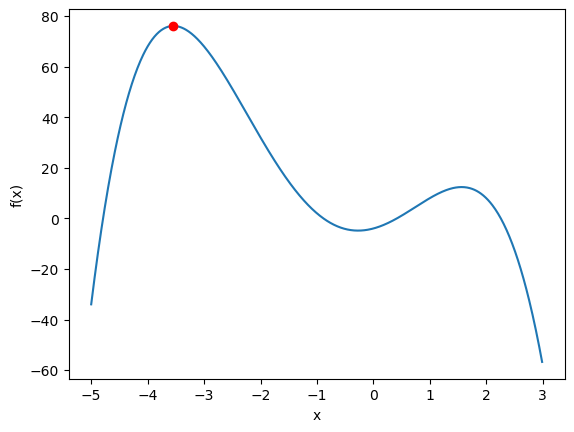

In [41]:
best_sol = last_pop[0]
print(best_sol.sol, best_sol.score)
plot_f(False)
plt.plot(best_sol.sol, best_sol.score, "o", color="red")
plt.show()

To plot the evolution of best solution, you can write:

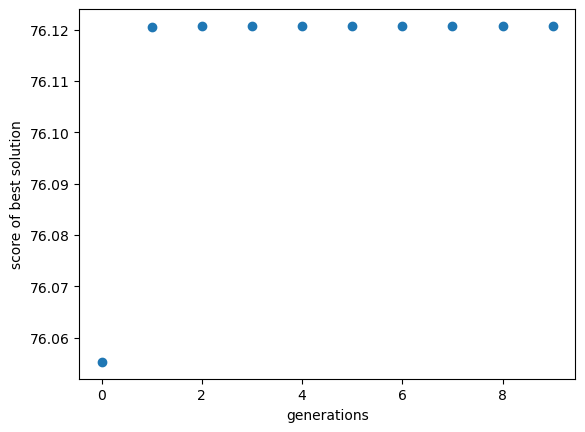

In [42]:
MA.plot_best_each_gen()

### Exercice 2

TODO: use those to class to find the maximum of the following function.

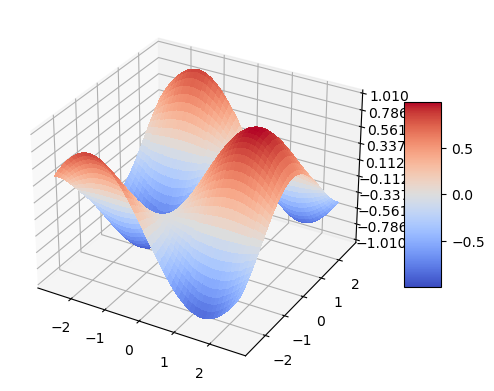

In [43]:
import numpy as np
from matplotlib import cm
from matplotlib.ticker import LinearLocator


def f(x,y):
    return np.sin(x) * np.cos(y)

f_min = -np.pi/1.2
f_max = np.pi/1.2

def plot_f():
    ratio = 100
    X = np.arange(f_min, f_max, 1/ratio)
    Y = np.arange(f_min, f_max, 1/ratio)
    X, Y = np.meshgrid(X, Y)
    Z = f(X,Y)

    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, antialiased=False)
    # Customize the z axis.
    ax.set_zlim(-1.01, 1.01)
    ax.zaxis.set_major_locator(LinearLocator(10))
    # Add a color bar which maps values to colors.
    fig.colorbar(surf, shrink=0.5, aspect=5)
plot_f()
plt.show()

#### Solution

[1.5697932975433608, -0.001703548050360118] 0.9999980459293034


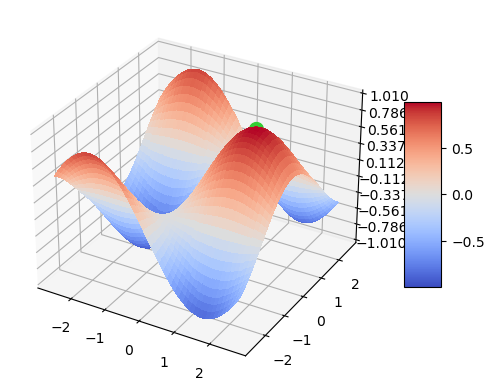

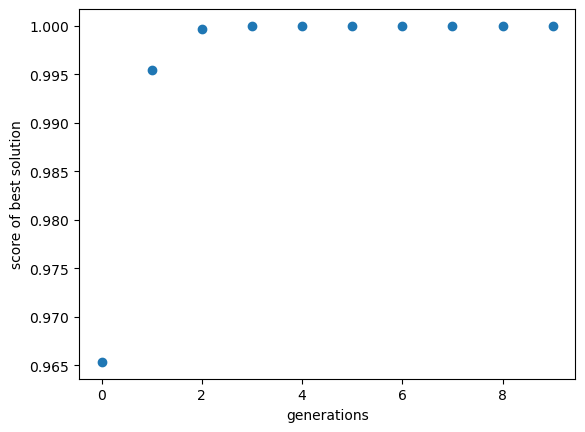

In [44]:
class MyAlgo(GeneticAlgo):
    def __init__(self, nb_gen=10, len_pop=100):
        super().__init__(nb_gen, len_pop)

    def score(self, x, y):
        return f(x, y)
        
    def gen_sol(self):
        x = rd.uniform(f_min, f_max)
        y = rd.uniform(f_min, f_max)
        return Solution([x,y], self.score(x,y))

    def cross_over(self, x, y):
        co_x = (x.sol[0]+y.sol[0])/2
        co_y = (x.sol[1]+y.sol[1])/2
        return Solution([co_x, co_y], self.score(co_x, co_y))
    
    def mutate(self, x):
        co_x = x.sol[0] + (-1)**rd.randint(0,1) * rd.random()/2
        co_y = x.sol[1] + (-1)**rd.randint(0,1) * rd.random()/2
        return Solution([co_x, co_y], self.score(co_x, co_y))
    
MA = MyAlgo()
last_pop = MA.algo(gen=20) #gen> nb_gen means that we don't print each index of generation
best_sol = last_pop[0]
print(best_sol.sol, best_sol.score)

plot_f()
plt.plot(best_sol.sol[0], best_sol.sol[1], best_sol.score, "o", color="limegreen", markersize=10)
plt.show()

MA.plot_best_each_gen()

### Exercice 3

Let $n=3$ and $V = \begin{bmatrix}
    12\\
    37\\
    15
\end{bmatrix} \in \mathcal{M}_n(\mathbb{R})$. Let $\mathcal{C} = \mathcal{M}_n(\{-K,...-1,1,...,K\})$ for $K=1000$. Note that the solution must be non-zero integer matrix and not real matrix.

Remenber that $\forall X \in \mathcal{C}$, $V^\top . X = \underset{i=1}{\overset{n}{\sum}} V_{i,1}.X_{i,1}$

Find $\underset{X\in\mathcal{C}}{argmin}\{|V^\top . X|\}$

In [45]:
n = 3
K = 1000
V = (12, 37, 15)

#### Solution

best solution of generation n°0: [-322, 192, 63] with score of: -3
best solution of generation n°1: [-238, 455, -282] with score of: -1
best solution of generation n°2: [-458, 611, -217] with score of: 0
best solution of generation n°3: [-458, 611, -217] with score of: 0
best solution of generation n°4: [-458, 611, -217] with score of: 0
best solution of generation n°5: [-458, 611, -217] with score of: 0
best solution of generation n°6: [-458, 611, -217] with score of: 0
best solution of generation n°7: [-458, 611, -217] with score of: 0
best solution of generation n°8: [-458, 611, -217] with score of: 0
best solution of generation n°9: [-458, 611, -217] with score of: 0
[-458, 611, -217] 0


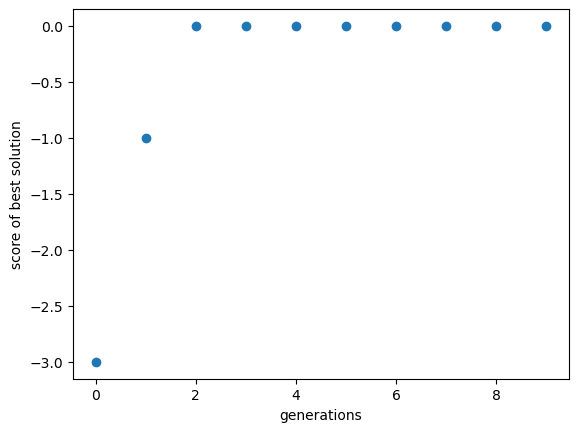

In [46]:
class MyAlgo(GeneticAlgo):
    def __init__(self, nb_gen=10, len_pop=100):
        super().__init__(nb_gen, len_pop)
        
    def score(self, x):
        sum = 0
        for i in range(n):
            sum += V[i] + x[i]
        return - np.absolute(sum) #we write a - because we want to find the minimum
        
    def gen_sol(self):
        x = [(-1)**rd.randint(0,1) * rd.randint(1,K) for _ in range(n)]
        return Solution(x, self.score(x))

    def cross_over(self, x, y):
        z = [0 for _ in range(n)]
        for i in range(n):
            new_val = int(round((x.sol[i]+y.sol[i])/2))
            if new_val == 0:
                new_val += (-1)**rd.randint(0,1)
            z[i] = new_val
        return Solution(z, self.score(z))
    
    def mutate(self, x):
        z = [x.sol[i] for i in range(n)]
        for i in range(n):
            if rd.random() <= 0.4:
                z[i] = (-1)**rd.randint(0,1) * rd.randint(1,K)
        return Solution(z, self.score(z))
    
    def fct_during_gen(self, actual_gen, actual_pop):
        print("best solution of generation n°" + str(actual_gen) + ':', actual_pop[0].sol, "with score of:", actual_pop[0].score)
    
MA = MyAlgo()
last_pop= MA.algo(gen=1)
best_sol = last_pop[0]
print(best_sol.sol, best_sol.score)

MA.plot_best_each_gen()